<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/dRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

Implementing subclassing of the tf.keras.layers.Layer Class through the newly defined DiagonalRNNCell. 

The code for the cell is mainly based on https://github.com/keras-team/keras/blob/v2.7.0/keras/layers/recurrent.py#L1255-L1456

In [2]:
class DiagonalRNNCell(tf.keras.layers.Layer):
    def __init__(self,
                 units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        if units < 0:
           raise ValueError(f'Received an invalid value for argument `units`, '
                       f'expected a positive integer, got {units}.') 
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.recurrent_initializer = tf.keras.initializers.get(recurrent_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)

        self.state_size = self.units
        self.output_size = self.units
        
        super(DiagonalRNNCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel')
        # The recurrent kernel shape is a vector and not a matrix
        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                                initializer=self.recurrent_initializer,
                                                name='recurrent_kernel')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias')
        else:
            self.bias = None
        self.built = True
    
    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.keras.backend.dot(inputs, self.kernel)
        if self.bias is not None:
            h = tf.keras.backend.bias_add(h, self.bias)
        # The output is computed through an element-wise multiplication
        output = h + prev_output * self.recurrent_kernel
        if self.activation is not None:
            output = self.activation(output)
        return output, [output]

In [3]:
# Example: building a dRNN using the custom cell

cell = DiagonalRNNCell(64)

inputs = tf.keras.layers.Input(shape=(1,1,))
layer = tf.keras.layers.RNN(cell)(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear')(layer)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='dRNN')
model.summary()

Model: "dRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
rnn (RNN)                    (None, 64)                192       
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

# Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras

Applying the model developed to the Scenario described at the following link: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 

The problem we are going to look at in this post is the "International Airline Passengers prediction problem".

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [5]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2021-11-08 16:20:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2021-11-08 16:20:56 (40.7 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



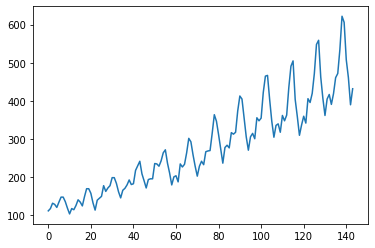

In [7]:
import pandas
import matplotlib.pyplot as plt

dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

96 48


In [9]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 1s - loss: 0.0206 - mse: 0.0206
Epoch 2/100
94/94 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 3/100
94/94 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 4/100
94/94 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 5/100
94/94 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 6/100
94/94 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 7/100
94/94 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 8/100
94/94 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 9/100
94/94 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 10/100
94/94 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 11/100
94/94 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 12/100
94/94 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 13/100
94/94 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 14/100
94/94 - 0s - loss: 0.0026 - mse: 0.0026
Epoch 15/100
94/94 - 0s - loss: 0.0024 - mse: 0.0024
Epoch 16/100
94/94 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 17/100
94/94 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 18/100
94/94 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 19/100
94/94 - 0s - loss: 0.0023 - mse: 0.0023
Ep

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.88 RMSE
Test Score: 50.92 RMSE


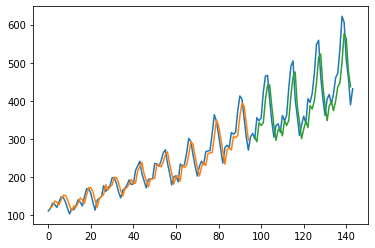

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()